In [1]:
import os
import math
import datetime
import json
import re

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

# from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
bert_ckpt_dir = os.path.join("../bert_models/pretrained_bert_model")
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt") #.data-00000-of-00001")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [3]:
classes = [0,1]
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
#   cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
#   logits = keras.layers.Dropout(0.5)(logits)
#   logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
  logits = keras.layers.Dense(units=1, activation="sigmoid")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [4]:
# model = create_model(data.max_seq_len, bert_ckpt_file)
model = create_model(60, bert_ckpt_file)

bert shape (None, 60, 768)
Done loading 196 BERT weights from: ../bert_models/pretrained_bert_model/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f20bf864c50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 60)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 60, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 109,481,473
Trainable params: 109,481,473
Non-trainable params: 0
_________________________________________________________________


In [6]:
# load dataset

data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

# load data and print sizes
# load data and print sizes
def get_dict(path):
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    return {datum['id'] : datum for datum in data}


train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

def get_text_data(dictionary):
    return [(datum['text'], datum['label']) for datum in dictionary.values()]

train_data = get_text_data(train_dict)
val_data = get_text_data(val_dict)
# test_data = get_text_data(test_dict)

8500
500
1000


In [7]:
# load the tokenizer from bert library
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
print(train_data[0][0], tokenizer.tokenize(train_data[0][0]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0][0])))

its their character not their color that matters ['its', 'their', 'character', 'not', 'their', 'color', 'that', 'matters']
[2049, 2037, 2839, 2025, 2037, 3609, 2008, 5609]


In [8]:
# tokenize the sequences
# https://colab.research.google.com/drive/1WQY_XxdiCVFzjMXnDdNfUjDFi0CN5hkT#scrollTo=TApTW_wLxoA9

MAX_SEQ_LEN = 50

def list_to_mats(l, tokenizer, pad_len):
    texts, labels = zip(*l)
    
    sequences = []
    for text in tqdm(texts):
        tokens = ["[CLS]"] + tokenizer.tokenize(text) + ["[SEP]"]
        tokens = [t for t in tokens if t[0]!='<'] # remove twitter specific text
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        sequences.append(token_ids)
    
    x = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=60, padding='post')
    y = np.asarray(labels)
    return x, y

x_train, y_train = list_to_mats(train_data, tokenizer, MAX_SEQ_LEN)
x_val, y_val = list_to_mats(val_data, tokenizer, MAX_SEQ_LEN)
# x_test, y_test = list_to_mats(test_data, tokenizer, MAX_SEQ_LEN)

print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

100%|██████████| 500/500 [00:00<00:00, 5958.63it/s]

Shape of data tensor: (8500, 60)
Shape of label tensor: (8500,)


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# shuffle data
indices = (np.arange(x_train.shape[0]))
np.random.shuffle(indices)
x_train, y_train = x_train[indices], y_train[indices]

history = model.fit(x_train, y_train, epochs=15, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/15
532/532 [==============================] - 631s 1s/step - loss: 0.7010 - accuracy: 0.6174 - val_loss: 0.8762 - val_accuracy: 0.5000
Epoch 2/15
532/532 [==============================] - 622s 1s/step - loss: 0.6725 - accuracy: 0.6222 - val_loss: 0.7904 - val_accuracy: 0.5000
Epoch 3/15
532/532 [==============================] - 626s 1s/step - loss: 0.6717 - accuracy: 0.6180 - val_loss: 0.9277 - val_accuracy: 0.5000
Epoch 4/15
532/532 [==============================] - 624s 1s/step - loss: 0.6680 - accuracy: 0.6262 - val_loss: 0.7055 - val_accuracy: 0.5000
Epoch 5/15
532/532 [==============================] - 622s 1s/step - loss: 0.6779 - accuracy: 0.6153 - val_loss: 0.7480 - val_accuracy: 0.5000
Epoch 6/15
532/532 [==============================] - 619s 1s/step - loss: 0.6706 - accuracy: 0.6260 - val_loss: 0.7008 - val_accuracy: 0.5000
Epoch 7/15
532/532 [==============================] - 621s 1s/step - loss: 0.6691 - accuracy: 0.6269 - val_loss: 0.7129 - val_accuracy: 0.5000

In [10]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

# get AUROC
preds = model.predict(x_val)
print('Test AUROC:', roc_auc_score(y_val, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0
print('Val acc:', accuracy_score(y_val, preds_bin))

# get F1
print('Val F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Val Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Val Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test AUROC: 0.496568
Val acc: 0.5
Val F1: 0.0
Val Precision: 1.0
Val Recall: 0.0


In [11]:
# accuracy scores with different threshold

preds_bin[preds>0.2] = 1
preds_bin[preds<=0.2] = 0
print('Test acc:', accuracy_score(y_val, preds_bin))
print('Test F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test acc: 0.5
Test F1: 0.6666666666666666
Test Precision: 0.5
Test Recall: 1.0


(0.0, 1.0)

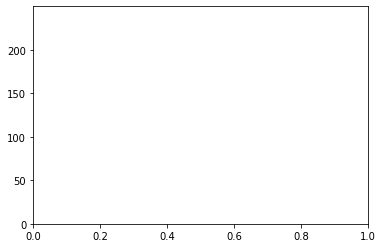

In [12]:
%matplotlib inline
plt.hist(preds)
plt.xlim(0,1)

In [13]:
print([n.item() for n in preds])

[0.36090120673179626, 0.36090120673179626, 0.3609011769294739, 0.3609011173248291, 0.36090120673179626, 0.3609011769294739, 0.36090123653411865, 0.3609012961387634, 0.3609011769294739, 0.36090123653411865, 0.36090123653411865, 0.36090120673179626, 0.36090120673179626, 0.3609011769294739, 0.36090123653411865, 0.3609011769294739, 0.36090120673179626, 0.36090120673179626, 0.36090120673179626, 0.3609011769294739, 0.3609011769294739, 0.3609011173248291, 0.36090120673179626, 0.3609011769294739, 0.3609011769294739, 0.36090123653411865, 0.36090120673179626, 0.36090120673179626, 0.3609011769294739, 0.3609011769294739, 0.3609011769294739, 0.36090120673179626, 0.36090123653411865, 0.3609011769294739, 0.3609011769294739, 0.3609011769294739, 0.3609011769294739, 0.3609011769294739, 0.36090120673179626, 0.3609011769294739, 0.3609011769294739, 0.36090123653411865, 0.36090120673179626, 0.36090123653411865, 0.36090120673179626, 0.3609011769294739, 0.3609011769294739, 0.36090120673179626, 0.3609012067317

In [23]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [24]:
tf.test.is_gpu_available()

False